In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 15  # Pode aumentar para 20 ou 30 se tiver GPU
CHANNELS = 3 # RGB

# Paths (adjusting relative to the notebook location)
PROJECT_ROOT = Path('..')
TRAIN_DIR = PROJECT_ROOT / 'data' / 'raw' / 'train'
VAL_DIR = PROJECT_ROOT / 'data' / 'raw' / 'val'

print(f"TensorFlow Version: {tf.__version__}")
print(f"Training on: {TRAIN_DIR.resolve()}")

/Users/cauegrassi/Dev/leaflens-ai/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0
Training on: /Users/cauegrassi/Dev/leaflens-ai/ml/data/raw/train


In [2]:
# Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Classes detected: {class_names}")

Found 14529 files belonging to 10 classes.
Found 3631 files belonging to 10 classes.
Classes detected: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache and Prefetch to optimize loading speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# Layer for resizing and normalizing (0-255 -> 0-1)
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

# Layer for data augmentation (prevents overfitting)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [8]:
# --- TRANSFER LEARNING ARCHITECTURE (MobileNetV2) ---

# 1. Base Model Setup
# We use MobileNetV2 pre-trained on ImageNet.
# 'include_top=False' excludes the final classification layers, as we will add our own custom head.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the Base Model
# We don't want to update the pre-trained weights during the initial training.
# The model already knows how to detect features (edges, textures).
base_model.trainable = False

# 3. Build the Model Architecture
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Pre-processing: MobileNetV2 expects pixel values between [-1, 1].
# This layer handles the rescaling automatically.
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

# Data Augmentation (Applied only during training)
x = data_augmentation(x)

# Pass inputs through the frozen base model
# training=False is important to keep BatchNormalization layers in inference mode
x = base_model(x, training=False)

# 4. Classification Head (The part we actually train)
# Convert features to a single vector per image
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularization to prevent overfitting

# Final output layer
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Combine inputs and outputs
model = tf.keras.Model(inputs, outputs)

model.summary()

/var/folders/l_/6cdjgq2916n__p7hpg6gph8m0000gn/T/ipykernel_53275/2091059277.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# --- COMPILE AND TRAIN ---

# 1. Compile the model
# Adam is the standard optimizer for deep learning.
# SparseCategoricalCrossentropy is used because our classes are integers (0, 1, 2), not one-hot vectors.
# from_logits=False because our last layer already has 'softmax' activation.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print(f"Starting training for {EPOCHS} epochs...")

# 2. Train the model
# We store the training process in 'history' to plot graphs later if needed.
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1
)

Starting training for 15 epochs...
Epoch 1/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 90s 185ms/step - accuracy: 0.7417 - loss: 0.8036 - val_accuracy: 0.8292 - val_loss: 0.5426
Epoch 2/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 90s 198ms/step - accuracy: 0.8491 - loss: 0.4625 - val_accuracy: 0.8438 - val_loss: 0.4767
Epoch 3/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 89s 197ms/step - accuracy: 0.8676 - loss: 0.4058 - val_accuracy: 0.8741 - val_loss: 0.3828
Epoch 4/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.8786 - loss: 0.3644 - val_accuracy: 0.8648 - val_loss: 0.3914
Epoch 5/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.8829 - loss: 0.3509 - val_accuracy: 0.8783 - val_loss: 0.3603
Epoch 6/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 90s 198ms/step - accuracy: 0.8875 - loss: 0.3356 - val_accuracy: 0.8708 - val_loss: 0.3852
Epoch 7/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 89s 196ms/step - accuracy: 0.8887 - loss: 0.3287 - val_accuracy: 0.8747 - val_loss: 0.3653
Epoch 8/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 89s 196m


Training Accuracy: 90.10%
Validation Accuracy: 86.09%
✅ Model saved successfully at: /Users/cauegrassi/Dev/leaflens-ai/ml/models/plant_disease_model_v1.keras


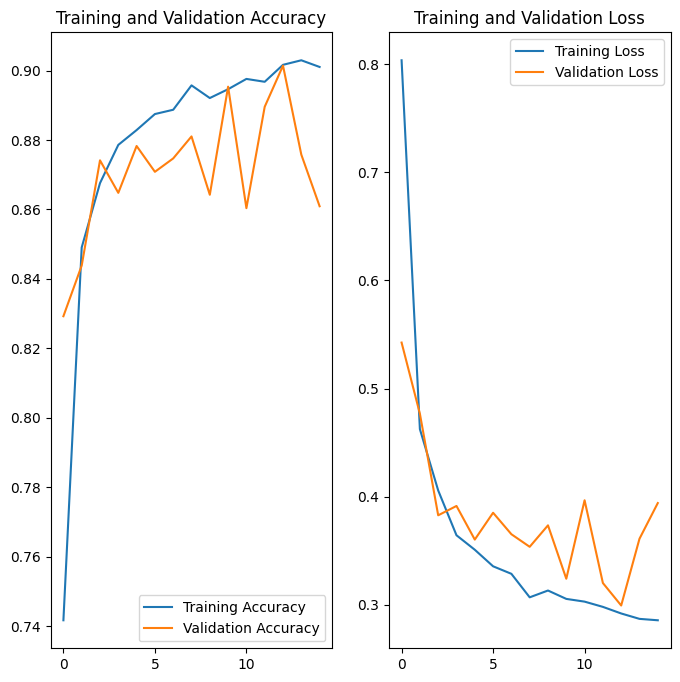

In [10]:
# --- EVALUATION AND SAVING ---

# 1. Check Final Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"\nTraining Accuracy: {acc[-1]*100:.2f}%")
print(f"Validation Accuracy: {val_acc[-1]*100:.2f}%")

# 2. Save the Model
# We go up one level from 'notebooks' to 'ml', then into 'models'
# Using pathlib makes this OS-independent (works on Windows/Mac/Linux)
models_dir = PROJECT_ROOT / 'models' 
models_dir.mkdir(parents=True, exist_ok=True) # Create folder if it doesn't exist

# Naming convention: includes version to manage updates easily
model_version = 1
model_name = f"plant_disease_model_v{model_version}.keras"
model_path = models_dir / model_name

model.save(model_path)

print(f"✅ Model saved successfully at: {model_path.resolve()}")

# 3. Optional: Plot Training History
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()